# EXP-2.1 for timing

Compare chlorophyll $a$ concentration vs time for different wintertime nitrate concentration.

# Set input directories

In [1]:
indir_sim1='../../run_20220722_0000_EXP2_1rbcsno3times0_25'
indir_sim2='../../run_20220722_0000_EXP2_1rbcsno3times0_50'
indir_sim3='../../run_20220722_0000_EXP2_1rbcsno3times1_00'
indir_sim4='../../run_20220722_0000_EXP2_1rbcsno3times2_00'
indir_sim5='../../run_20220722_0000_EXP2_1rbcsno3times4_00'

# First, load libraries

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path
import sys

sys.path.insert(1, os.path.join(sys.path[0], '..'))

import netcdf_tools
import read_mitgcm
import vstats

plt.close("all")

# Select year

In [3]:
years=range(1,11)
nbyears=len(years)
iyeartempo=nbyears
first_year=np.arange(0,365)
last_year=np.arange(365*(nbyears-1)+0,365*(nbyears-1)+365)
array1d_iT1y_iT=last_year
first_year366=np.arange(0,366) # first year for heatmaps

# Grid

drF is the r cell face separation, meaning the thickness of each depth layer (in m)

it corresponds to delR on https://mitgcm.readthedocs.io/en/latest/getting_started/getting_started.html#grid

In [4]:
gridfile='../grid.t001.nc';
drF=netcdf_tools.read_netcdf(gridfile,'drF')

# Observations

## Observations: Ice concentration

Break-up was on 18 July 2016 (Oziel et al., 2019).

In [5]:
obsice=np.empty(365)
obsice[:]=np.NaN
obsice[0:199]=1
obsice[199]=0

Day of *in situ* sea ice breakup:

In [6]:
iT15_start_obs=next(i for i,v in enumerate(obsice) if v < 0.15)

## Output from model NEMO-LIM3 and input into package gud of MITgcm: sea ice concentration

In [7]:
ice=np.fromfile('../../../gud_1d_35+16/input_noradtrans/input/siarea.nemo.2016.365.32bits.bin',
                dtype='>f')

In [8]:
iT15=np.nonzero(ice<0.15)[0]
iT15_start=iT15[0]
iT15_end=iT15[-1]

In [9]:
iT90=np.nonzero(ice<0.90)[0]
iT90_start=iT90[0]
iT90_end=iT90[-1]

In [10]:
iT15_start

209

In [11]:
iT90_start

194

# Simulations

## Simulations: Chlorophyll $a$ vertically integrated (0-100m)

in $mg\ Chl\ a\ m^{-2}$

In [12]:
def get_array1d_iT_vintchl(indir,array1d_iT1y_iT):
    chlfile=os.path.join(indir,'chl.0000000000.t001.nc')
    # mg Chl-a m^-3
    array2d_idepth_iT_chlfull=\
    read_mitgcm.get_array2d_idepth_iT_chlfull(chlfile)
    # mg Chl-a m^-2
    array1d_iT_vintchlfull\
    =vstats.vint(
        array2d_idepth_iT_tracer=array2d_idepth_iT_chlfull,
        array1d_idepth_delR=drF,
        depth_end=-100)
    array1d_iT_vintchl=array1d_iT_vintchlfull[array1d_iT1y_iT]
    return array1d_iT_vintchl

In [13]:
array1d_iT_sim1vintchl=get_array1d_iT_vintchl(indir_sim1,array1d_iT1y_iT)
array1d_iT_sim2vintchl=get_array1d_iT_vintchl(indir_sim2,array1d_iT1y_iT)
array1d_iT_sim3vintchl=get_array1d_iT_vintchl(indir_sim3,array1d_iT1y_iT)
array1d_iT_sim4vintchl=get_array1d_iT_vintchl(indir_sim4,array1d_iT1y_iT)
array1d_iT_sim5vintchl=get_array1d_iT_vintchl(indir_sim5,array1d_iT1y_iT)

# Plot

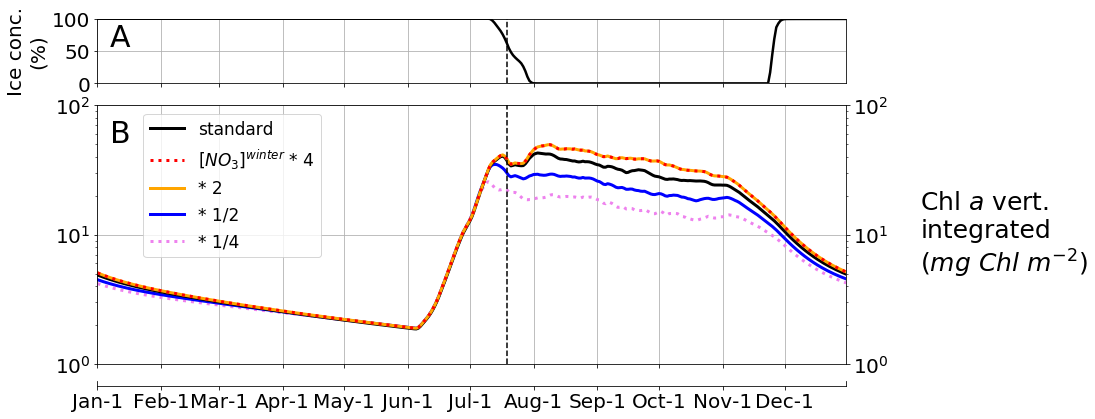

In [14]:
with plt.style.context('chl_vs_time.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
                   181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    fig,axs=plt.subplots(3,1,sharex=False,figsize=(16, 6))

    # --- ICE CONCENTRATIONS
    ax=axs[0]
    ax.plot(first_year,ice*100,'k-',lw=2.5)
    ax.set_xlim(first_year[0],first_year[-1])
    xlims=ax.get_xlim()
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_yticks([0,50,100])
    ax.set_ylabel('Ice conc.\n(%)')
    ax.set_ylim(0,100)
    ax.grid()
    plt.text(0.03,0.7,'A',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    # adding the vertical line at 15% of observed ice
    ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- CHLOROPHYLL A
    ax=axs[1]
    h1=ax.plot(first_year,array1d_iT_sim1vintchl,
           ':', lw=3,color='violet',label='* 1/4')
    h2=ax.plot(first_year,array1d_iT_sim2vintchl,
           '-',lw=3,color='blue',  label='* 1/2')
    h3=ax.plot(first_year,array1d_iT_sim3vintchl,
           '-', lw=3,color='black', label='standard')
    h4=ax.plot(first_year,array1d_iT_sim4vintchl,
           '-',lw=3,color='orange',label='* 2')
    h5=ax.plot(first_year,array1d_iT_sim4vintchl,
           ':',lw=3,color='red',   label='${[NO_3]}^{winter}$ * 4')
    ax.set_yscale('log')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.yaxis.tick_right()
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(labelleft=True, labelright=True)
    ax.set_ylim(1E0,1E2)
    ax.grid()
    ax.text(400,1E1,'Chl $a$ vert.\nintegrated\n($mg\ Chl\ m^{-2}$)',
            horizontalalignment = 'left',verticalalignment = 'center',fontsize=25,)
    #get handles and labels
    handles, legend_labels = ax.get_legend_handles_labels()
    #specify order of items in legend
    order = [2,4,3,1,0]
    #add legend to plot
    ax.legend([handles[idx] for idx in order],
              [legend_labels [idx] for idx in order],
               loc='upper left',
               bbox_to_anchor=(0.05,1.00))
    plt.text(0.03,0.89,'B',
            horizontalalignment = 'center',verticalalignment='center',
            transform=ax.transAxes, fontsize=30)
    # adding the vertical line at 15% of observed ice
    ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- ADDITIONAL X-AXIS
    ax=axs[2]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.12,0.80  ,0.65,.15])
    axs[1].set_position( [0.12,0.15  ,0.65,.60])
    axs[2].set_position( [0.12,0.10  ,0.65,.01])

    # --- SAVE
    plt.savefig('chl_vs_time_diff_nitrate.png')